In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import probit
import numpy as np

pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)
plt.style.use('ggplot')

# Table of Contents

1. [Read Data](#Read-Data)
2. [Define Supporting Functions](#Define-Supporting-Functions)
3. [Cross-Sectional Regressions-Final screenshot](#Cross-Sectional-Regressions-Final-screenshot)
    1. [Includes Login](#Includes-Login)
    2. [Includes Careers Page](#Includes-Careers-Page)
    3. [Webpage Size](#Webpage-Size)
    4. [Number of A Tags](#Number-of-A-Tags)
4. [Difference in final screenshot and end year](#Difference-in-final-screenshot-and-end-year)
5. [Cross-Sectional Regression Table](#Cross-Sectional-Regression-Table)
6. [Cross-Sectional Regressions-Difference Between Final Screenshots](#Cross-Sectional-Regressions-Difference-Between-Final-Screenshots)
    1. [Change in Website Size](#Change-in-Website-Size)


In [9]:
## Read Data
html = pd.read_csv('../data/4_final_webpage_metadata.csv')

In [10]:
# Filter only clear successes and failures
html = html[html.ownershipstatus.isin(["Out of Business", "Publicly-held", "Acquired/Merged"])]

In [11]:
# Remove all webpages with size 0
html = html[html['website_size_kb'] != 0]

In [12]:
html["Failed"] = (html.ownershipstatus == "Out of Business").astype(int)
html["has_exit"] = (html["exit_date"].isna() == False).astype('int8')
html["end_yr"] = html["exit_date"].str.slice(start=0, stop=4).astype('float' ,errors='ignore').fillna(2023)
html["start_yr"] = html["startdate"].str.slice(start=0, stop=4).fillna(html["lastVC"].str.slice(start=0, stop=4)).astype('float', errors='ignore')
html["lifespan"] = html["end_yr"] - html["start_yr"]

In [28]:
html.head(200)

,entityid,yr_from_start,capture_yr,capture_m,file_path,file_exists,website_size_kb,careers,blog,login,contact,team,about,news,faq,call_to_action,testimonial,title,description,keywords,p_count,h_count,img_count,a_count,table_count,form_count,script_count,entityname,new_industrygroup,state,weburl,pb_companyid,startdate,lastVC,ownershipstatus,exit_date,Failed,has_exit,end_yr,start_yr,lifespan,l3g_website_size_kb_x,l3g_p_count_x,l3g_h_count_x,l3g_a_count_x,l3g_img_count_x,l3g_website_size_kb_y,l3g_p_count_y,l3g_h_count_y,l3g_a_count_y,l3g_img_count_y,l3g_table_count,l3g_form_count,l3g_script_count
0,100035,5.0,2001,9,data/html/100035/2001/09/index.html,1,1.793945,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4,Tesaria,Information Technology,CA,www.tesaria.com,NaN,1997-02-01,2000-06-30,Out of Business,NaN,1,0,2023.0,1997.0,26.0,2.660156,0.0,0.0,0.0,0.0,2.660156,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,100035,5.0,2002,1,data/html/100035/2002/01/index.html,1,1.791016,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4,Tesaria,Information Technology,CA,www.tesaria.com,NaN,1997-02-01,2000-06-30,Out of Business,NaN,1,0,2023.0,1997.0,26.0,2.660156,0.0,0.0,0.0,0.0,2.660156,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100035,5.5,2002,7,data/html/100035/2002/07/index.html,1,9.054688,1,0,0,1,0,0,1,0,0,0,1,1,1,6,0,23,23,7,0,3,Tesaria,Information Technology,CA,www.tesaria.com,NaN,1997-02-01,2000-06-30,Out of Business,NaN,1,0,2023.0,1997.0,26.0,2.660156,0.0,0.0,0.0,0.0,2.660156,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,100035,6.0,2002,9,data/html/100035/2002/09/index.html,1,9.054688,1,0,0,1,0,0,1,0,0,0,1,1,1,6,0,23,23,7,0,3,Tesaria,Information Technology,CA,www.tesaria.com,NaN,1997-02-01,2000-06-30,Out of Business,NaN,1,0,2023.0,1997.0,26.0,2.660156,0.0,0.0,0.0,0.0,2.660156,0.0,0.0,0.0,0.0,0.0,0.0,4.0
4,100035,15.5,2012,8,data/html/100035/2012/08/index.html,1,0.032227,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Tesaria,Information Technology,CA,www.tesaria.com,NaN,1997-02-01,2000-06-30,Out of Business,NaN,1,0,2023.0,1997.0,26.0,2.660156,0.0,0.0,0.0,0.0,2.660156,0.0,0.0,0.0,0.0,0.0,0.0,4.0
5,100035,16.0,2013,2,data/html/100035/2013/02/index.html,1,0.032227,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Tesaria,Information Technology,CA,www.tesaria.com,NaN,1997-02-01,2000-06-30,Out of Business,NaN,1,0,2023.0,1997.0,26.0,2.660156,0.0,0.0,0.0,0.0,2.660156,0.0,0.0,0.0,0.0,0.0,0.0,4.0
6,100035,16.5,2013,8,data/html/100035/2013/08/index.html,1,0.032227,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Tesaria,Information Technology,CA,www.tesaria.com,NaN,1997-02-01,2000-06-30,Out of Business,NaN,1,0,2023.0,1997.0,26.0,2.660156,0.0,0.0,0.0,0.0,2.660156,0.0,0.0,0.0,0.0,0.0,0.0,4.0
7,100035,17.5,2014,8,data/html/100035/2014/08/index.html,1,0.032227,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Tesaria,Information Technology,CA,www.tesaria.com,NaN,1997-02-01,2000-06-30,Out of Business,NaN,1,0,2023.0,1997.0,26.0,2.660156,0.0,0.0,0.0,0.0,2.660156,0.0,0.0,0.0,0.0,0.0,0.0,4.0
8,100035,25.0,2021,12,data/html/100035/2021/12/index.html,1,2.692383,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,Tesaria,Information Technology,CA,www.tesaria.com,NaN,1997-02-01,2000-06-30,Out of Business,NaN,1,0,2023.0,1997.0,26.0,2.660156,0.0,0.0,0.0,0.0,2.660156,0.0,0.0,0.0,0.0,0.0,0.0,4.0
9,100065,2.0,1998,12,data/html/100065/1998/12/index.html,1,8.354492,0,0,1,1,0,1,1,0,0,0,1,0,0,5,0,11,9,5,0,4,TetraData,Information Technology,SC,www.tetradata.com,NaN,1997-01-01,2006-08-25,Acquired/Merged,2006-08-25,0,1,2006.0,1997.0,9.0,0.006836,0.0,0.0,1.0,-1.0,0.006836,0.0,0.0,1.0,-1.0,0.0,0.0,0.0


**The main dataset we'll using for regressions (for now):**

In [13]:
data = html.groupby('entityid').last()
# Convert to log website size
data['websize_log'] = np.log(data['website_size_kb'])
data['a_log'] = np.log(data['a_count']).replace([-np.inf], 0)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
data['a_log'].describe()

count    16795.000000
mean         2.866734
std          1.680607
min          0.000000
25%          1.791759
50%          3.332205
75%          4.094345
max          8.376090
Name: a_log, dtype: float64

## Define Supporting Functions

In [7]:
# This function plots the regressions for us. Takes in an independent variable of 
# interest (this will be plotted on the Y axis for better readbility), a control, 
# and options to plot industry individually and or/save

def plot_freg(y, data, control=None, industry=False, save=None):
    # Always do most basic OLS
    sns.regplot(x='Failed', y=y, data=data, x_estimator=np.mean, color='g', label='Base OLS')
    
    if not industry:
        sns.regplot(x='Failed', y=y, data=data, x_estimator=np.mean, y_partial=control, \
                    color='b', label=f'Controlling for {control}');
        plt.legend()
    else:
        ind_groups = data.groupby('new_industrygroup')
        for name, group in ind_groups:
            # We're gonna ignore these industries for now
            ind_ignore = ["To Be Assigned", "Energy and Utilities", "Industrial Goods and Materials"]
            if name not in ind_ignore:
                sns.regplot(x='Failed', y=y, data=group, x_estimator=np.mean, y_partial=control, label=name);
        if control:
            plt.title(f'Predicting failure on {y} by industry, controlling for {control}')
        else:
            plt.title(f'Predicting failure on {y} by industry')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');
    plt.xticks([0,1])
    if save:
        plt.savefig(save, dpi=200, bbox_inches='tight')

In [8]:
def run_model(x, control=[]):
    X = data[x]
    for y in control:
        if data[y].nunique() < 100:
            y_dummies = pd.get_dummies(data[y], prefix=y, drop_first=True)
            X = pd.concat([X, y_dummies], axis=1)
    X = sm.add_constant(X)
    mod = sm.OLS(data['Failed'], X).fit()
    return mod

In [9]:
def run_probit(x, control=[]):
    X = data[x]
    for y in control:
        if data[y].nunique() < 100:
            y_dummies = pd.get_dummies(data[y], prefix=y, drop_first=True)
            X = pd.concat([X, y_dummies], axis=1)
    X = sm.add_constant(X)
    mod = sm.Probit(data['Failed'], X).fit()
    return mod

## Cross-Sectional Regressions-Final screenshot

### Includes Login

In [13]:
run_model('login').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Failed   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     13.31
Date:                Thu, 13 Jul 2023   Prob (F-statistic):           0.000265
Time:                        16:44:54   Log-Likelihood:                -10359.
No. Observations:               16795   AIC:                         2.072e+04
Df Residuals:                   16793   BIC:                         2.074e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2864      0.004     71.619      0.000       0.279       0.294
login         -0.0291      0.008     -3.648      0.000      -0.045      -0.013
==============================================================================
Omnibus:                     6427.884   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3449.298
Skew:                           0.984   Prob(JB):                         0.00
Kurtosis:                       1.972   Cond. No.                         2.48
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Controlling for end year**

In [14]:
run_model('login', control=['end_yr']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Failed   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     789.9
Date:                Thu, 13 Jul 2023   Prob (F-statistic):               0.00
Time:                        16:44:54   Log-Likelihood:                -3474.4
No. Observations:               16795   AIC:                             7005.
Df Residuals:                   16767   BIC:                             7221.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.596e-14      0.133   -1.2e-13      1.000      -0.261       0.261
login            -0.0467      0.005     -8.656      0.000      -0.057      -0.036
end_yr_1998.0     0.0049      0.150      0.033      0.974      -0.289       0.298
end_yr_1999.0     0.0007      0.136      0.005      0.996      -0.265       0.266
end_yr_2000.0     0.0019      0.135      0.014      0.989      -0.262       0.266
end_yr_2001.0     0.0029      0.135      0.021      0.983      -0.261       0.267
end_yr_2002.0     0.0027      0.135      0.020      0.984      -0.261       0.267
end_yr_2003.0     0.0066      0.135      0.049      0.961      -0.258       0.271
end_yr_2004.0     0.0018      0.134      0.014      0.989      -0.261       0.265
end_yr_2005.0     0.0063      0.134      0.047      0.963      -0.257       0.270
end_yr_2006.0     0.0069      0.134      0.052      0.959      -0.256       0.270
end_yr_2007.0     0.0095      0.134      0.071      0.944      -0.253       0.272
end_yr_2008.0     0.0238      0.134      0.177      0.859      -0.240       0.287
end_yr_2009.0     0.0121      0.134      0.090      0.928      -0.251       0.275
end_yr_2010.0     0.0142      0.134      0.106      0.916      -0.248       0.277
end_yr_2011.0     0.0142      0.134      0.106      0.915      -0.248       0.277
end_yr_2012.0     0.0137      0.134      0.102      0.918      -0.249       0.276
end_yr_2013.0     0.0172      0.134      0.129      0.898      -0.245       0.279
end_yr_2014.0     0.0152      0.134      0.114      0.909      -0.247       0.277
end_yr_2015.0     0.0155      0.134      0.116      0.908      -0.247       0.278
end_yr_2016.0     0.0174      0.134      0.130      0.897      -0.245       0.280
end_yr_2017.0     0.0158      0.134      0.118      0.906      -0.246       0.278
end_yr_2018.0     0.0138      0.134      0.103      0.918      -0.248       0.276
end_yr_2019.0     0.0147      0.134      0.110      0.913      -0.247       0.277
end_yr_2020.0     0.0788      0.141      0.561      0.575      -0.197       0.354
end_yr_2021.0     0.0275      0.134      0.205      0.838      -0.236       0.291
end_yr_2022.0     0.0398      0.134      0.296      0.767      -0.223       0.303
end_yr_2023.0     0.6975      0.133      5.235      0.000       0.436       0.959
==============================================================================
Omnibus:                     2809.866   Durbin-Watson:                   1.611
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4537.773
Skew:                          -1.151   Prob(JB):                         0.00
Kurtosis:                       4.089   Cond. No.                         342.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of th

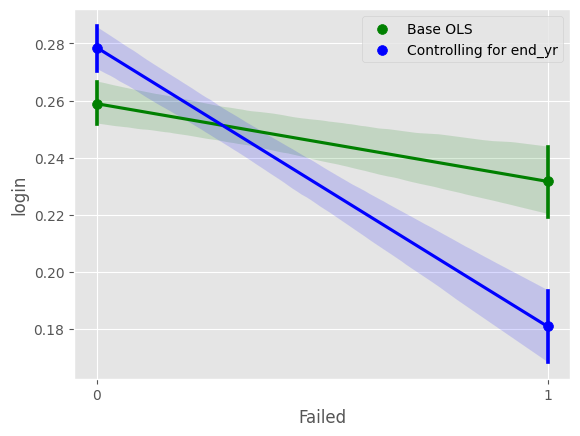

In [241]:
plot_freg('login', data=data, control='end_yr', save='login_basic.png')

**Control for industry _and_ end year**

In [16]:
run_model('login', control=['end_yr', 'new_industrygroup']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Failed   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     642.5
Date:                Thu, 13 Jul 2023   Prob (F-statistic):               0.00
Time:                        16:44:56   Log-Likelihood:                -3359.0
No. Observations:               16795   AIC:                             6788.
Df Residuals:                   16760   BIC:                             7059.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                               -0.0097      0.132     -0.073      0.942      -0.269       0.250
login                                               -0.0577      0.005    -10.572      0.000      -0.068      -0.047
end_yr_1998.0                                        0.0056      0.149      0.038      0.970      -0.286       0.297
end_yr_1999.0                                       -0.0142      0.135     -0.105      0.916      -0.278       0.250
end_yr_2000.0                                       -0.0102      0.134     -0.076      0.939      -0.272       0.252
end_yr_2001.0                                       -0.0038      0.134     -0.028      0.978      -0.266       0.258
end_yr_2002.0                                       -0.0030      0.134     -0.022      0.982      -0.265       0.259
end_yr_2003.0                                        0.0037      0.134      0.028      0.978      -0.259       0.266
end_yr_2004.0                                        0.0042      0.133      0.032      0.975      -0.257       0.266
end_yr_2005.0                                        0.0108      0.134      0.081      0.936      -0.251       0.273
end_yr_2006.0                                        0.0086      0.133      0.065      0.949      -0.253       0.270
end_yr_2007.0                                        0.0112      0.133      0.084      0.933      -0.250       0.272
end_yr_2008.0                                        0.0219      0.133      0.164      0.870      -0.240       0.283
end_yr_2009.0                                        0.0134      0.133      0.101      0.920      -0.248       0.275
end_yr_2010.0                                        0.0142      0.133      0.107      0.915      -0.246       0.275
end_yr_2011.0                                        0.0119      0.133      0.090      0.929      -0.249       0.273
end_yr_2012.0                                        0.0134      0.133      0.101      0.920      -0.247       0.274
end_yr_2013.0                                        0.0177      0.133      0.133      0.894      -0.243       0.278
end_yr_2014.0                                        0.0187      0.133      0.141      0.888      -0.242       0.279
end_yr_2015.0                                        0.0203      0.133      0.153      0.879      -0.240       0.281
end_yr_2016.0                                        0.0211      0.133      0.159      0.874      -0.239       0.282
end_yr_2017.0                                        0.0183      0.133      0.138      0.891      -0.242       0.279
end_yr_2018.0                                        0.0172      0.133      0.130      0.897      -0.243       0.277
end_yr_2019.0                            

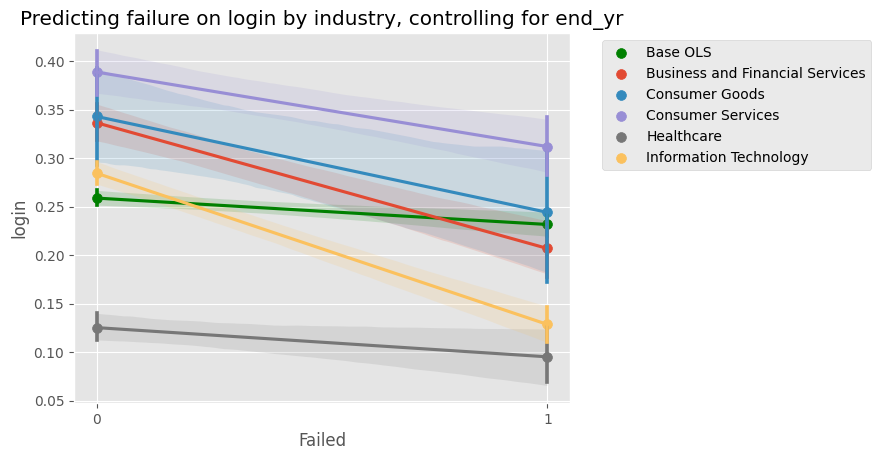

In [17]:
plot_freg('login', data=data, control='end_yr', industry=True)

### Includes Careers Page

In [18]:
run_model('careers').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Failed   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     854.4
Date:                Thu, 13 Jul 2023   Prob (F-statistic):          3.05e-183
Time:                        16:44:59   Log-Likelihood:                -9948.9
No. Observations:               16795   AIC:                         1.990e+04
Df Residuals:                   16793   BIC:                         1.992e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3738      0.005     79.873      0.000       0.365       0.383
careers       -0.1976      0.007    -29.230      0.000      -0.211      -0.184
==============================================================================
Omnibus:                     4494.391   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2909.475
Skew:                           0.905   Prob(JB):                         0.00
Kurtosis:                       2.062   Cond. No.                         2.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Controlling for end year**

In [19]:
run_model('careers', control=['end_yr']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Failed   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     818.5
Date:                Thu, 13 Jul 2023   Prob (F-statistic):               0.00
Time:                        16:44:59   Log-Likelihood:                -3305.6
No. Observations:               16795   AIC:                             6667.
Df Residuals:                   16767   BIC:                             6884.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0198      0.132      0.150      0.881      -0.239       0.278
careers          -0.0989      0.005    -20.418      0.000      -0.108      -0.089
end_yr_1998.0    -0.0042      0.148     -0.028      0.978      -0.295       0.286
end_yr_1999.0    -0.0065      0.134     -0.049      0.961      -0.270       0.256
end_yr_2000.0    -0.0060      0.133     -0.045      0.964      -0.267       0.255
end_yr_2001.0     0.0016      0.133      0.012      0.991      -0.260       0.263
end_yr_2002.0    -0.0034      0.133     -0.026      0.979      -0.265       0.258
end_yr_2003.0    -0.0036      0.133     -0.027      0.979      -0.265       0.258
end_yr_2004.0    -0.0060      0.133     -0.045      0.964      -0.267       0.255
end_yr_2005.0     0.0103      0.133      0.077      0.938      -0.251       0.271
end_yr_2006.0     0.0157      0.133      0.118      0.906      -0.245       0.276
end_yr_2007.0     0.0280      0.133      0.211      0.833      -0.232       0.288
end_yr_2008.0     0.0419      0.133      0.315      0.753      -0.219       0.303
end_yr_2009.0     0.0272      0.133      0.205      0.838      -0.233       0.288
end_yr_2010.0     0.0397      0.133      0.299      0.765      -0.220       0.299
end_yr_2011.0     0.0418      0.132      0.315      0.753      -0.218       0.301
end_yr_2012.0     0.0435      0.132      0.328      0.743      -0.216       0.303
end_yr_2013.0     0.0468      0.132      0.353      0.724      -0.213       0.306
end_yr_2014.0     0.0486      0.132      0.367      0.714      -0.211       0.308
end_yr_2015.0     0.0476      0.132      0.359      0.719      -0.212       0.307
end_yr_2016.0     0.0545      0.132      0.411      0.681      -0.205       0.314
end_yr_2017.0     0.0517      0.132      0.391      0.696      -0.208       0.311
end_yr_2018.0     0.0405      0.132      0.306      0.760      -0.219       0.300
end_yr_2019.0     0.0519      0.132      0.392      0.695      -0.207       0.311
end_yr_2020.0     0.1001      0.139      0.719      0.472      -0.173       0.373
end_yr_2021.0     0.0581      0.133      0.436      0.662      -0.203       0.319
end_yr_2022.0     0.0593      0.133      0.446      0.656      -0.201       0.320
end_yr_2023.0     0.7031      0.132      5.330      0.000       0.444       0.962
==============================================================================
Omnibus:                     2694.463   Durbin-Watson:                   1.616
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4283.705
Skew:                          -1.116   Prob(JB):                         0.00
Kurtosis:                       4.067   Cond. No.                         366.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of th

**Control for end year and industry**

In [20]:
run_model('careers', control=['end_yr']).rsquared

0.5686055079075668

In [21]:
run_model('careers', control=['new_industrygroup', 'end_yr']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Failed   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     663.5
Date:                Thu, 13 Jul 2023   Prob (F-statistic):               0.00
Time:                        16:44:59   Log-Likelihood:                -3205.1
No. Observations:               16795   AIC:                             6480.
Df Residuals:                   16760   BIC:                             6751.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                                0.0067      0.131      0.051      0.959      -0.251       0.264
careers                                             -0.0995      0.005    -20.589      0.000      -0.109      -0.090
new_industrygroup_Consumer Goods                    -0.0744      0.014     -5.303      0.000      -0.102      -0.047
new_industrygroup_Consumer Services                  0.0561      0.008      7.389      0.000       0.041       0.071
new_industrygroup_Energy and Utilities              -0.0083      0.020     -0.418      0.676      -0.047       0.031
new_industrygroup_Healthcare                        -0.0183      0.008     -2.429      0.015      -0.033      -0.004
new_industrygroup_Industrial Goods and Materials    -0.1028      0.016     -6.378      0.000      -0.134      -0.071
new_industrygroup_Information Technology             0.0211      0.006      3.422      0.001       0.009       0.033
new_industrygroup_To Be Assigned                     0.2848      0.293      0.971      0.331      -0.290       0.860
end_yr_1998.0                                       -0.0033      0.147     -0.023      0.982      -0.292       0.286
end_yr_1999.0                                       -0.0175      0.133     -0.131      0.896      -0.279       0.244
end_yr_2000.0                                       -0.0142      0.132     -0.107      0.915      -0.274       0.245
end_yr_2001.0                                       -0.0020      0.133     -0.015      0.988      -0.262       0.258
end_yr_2002.0                                       -0.0070      0.133     -0.053      0.958      -0.267       0.253
end_yr_2003.0                                       -0.0049      0.133     -0.037      0.971      -0.265       0.255
end_yr_2004.0                                       -0.0025      0.132     -0.019      0.985      -0.262       0.257
end_yr_2005.0                                        0.0154      0.132      0.116      0.908      -0.244       0.275
end_yr_2006.0                                        0.0179      0.132      0.136      0.892      -0.241       0.277
end_yr_2007.0                                        0.0301      0.132      0.228      0.819      -0.228       0.289
end_yr_2008.0                                        0.0401      0.132      0.303      0.762      -0.219       0.299
end_yr_2009.0                                        0.0290      0.132      0.220      0.826      -0.230       0.288
end_yr_2010.0                                        0.0400      0.132      0.304      0.761      -0.218       0.298
end_yr_2011.0                                        0.0402      0.132      0.305      0.760      -0.218       0.298
end_yr_2012.0                            

**Plot**

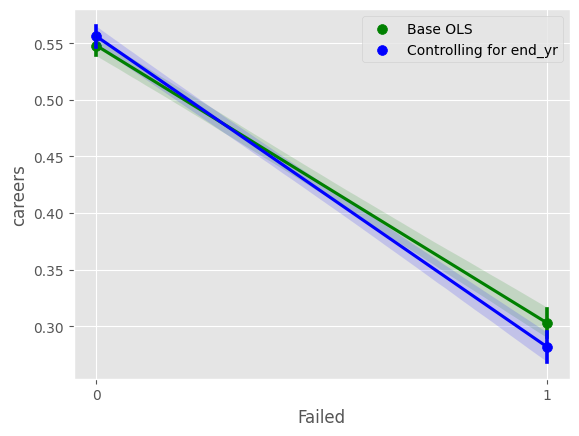

In [22]:
plot_freg('careers', data, 'end_yr')

**Plot for industry**

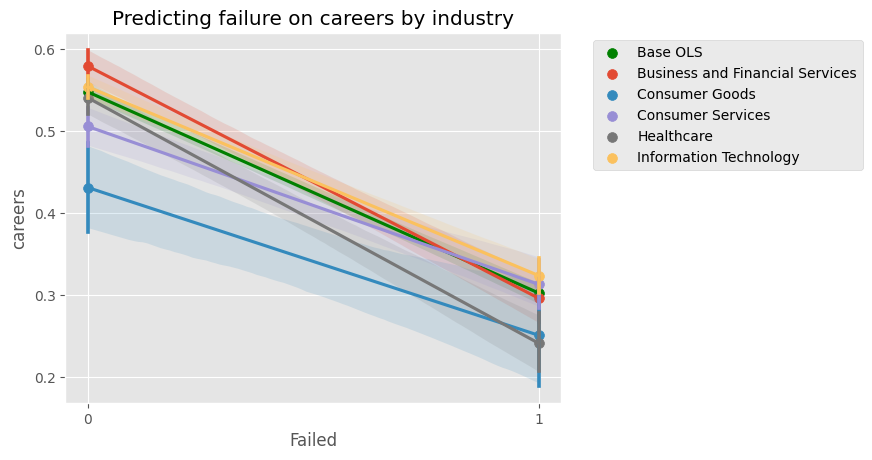

In [23]:
plot_freg('careers', data, industry=True, save='industry_graph_simple.png')

**Plot for industry, controlling for end year**

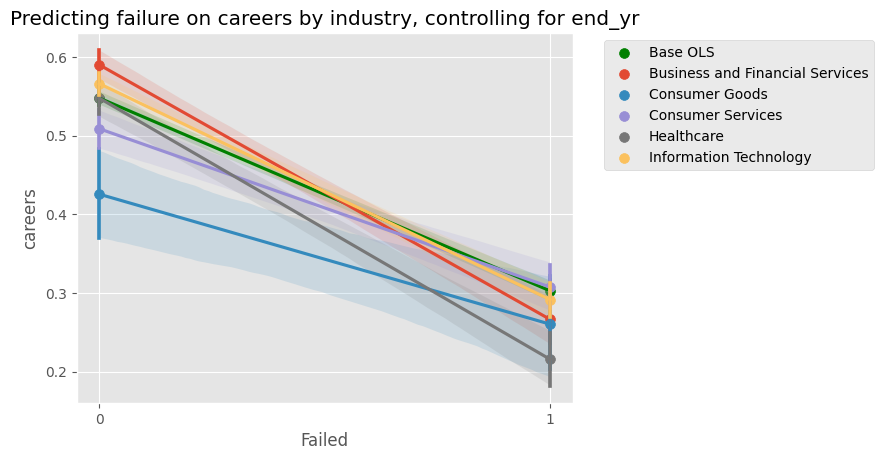

In [24]:
plot_freg('careers', data, control='end_yr', industry=True, save='careers_complex.png')

### Webpage Size

Setup

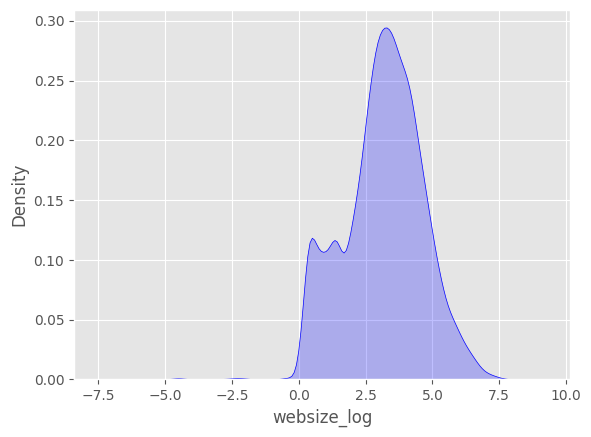

In [25]:
# Check out distribution
sns.kdeplot(data['websize_log'], color='b', fill='b');

**OLS Regression**

In [296]:
run_model('websize_log')

KeyError: 'websize_log'

**Control for year**

In [27]:
run_model('websize_log', control=['capture_yr']).rsquared

0.34809891756918476

**Control for industry**

In [28]:
run_model('websize_log', control=['new_industrygroup']).rsquared

0.05330245203738504

**Plot, controlling for end year**

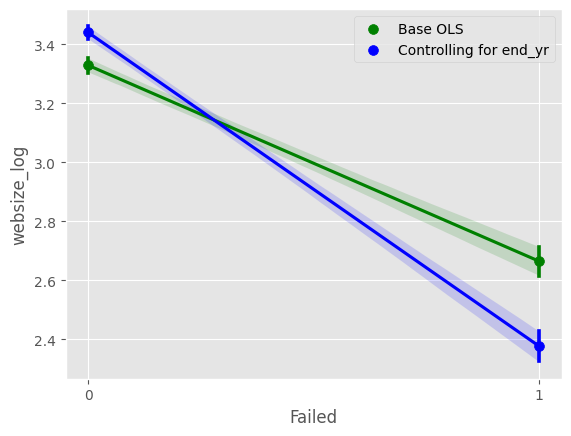

In [29]:
plot_freg('websize_log', data, control='end_yr')

**Industry Plot**

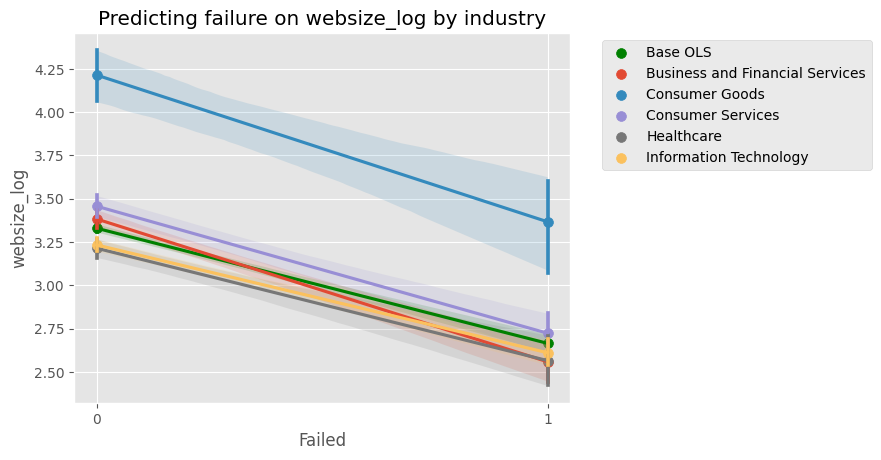

In [30]:
plot_freg('websize_log', data, industry=True)

**Plot for industry, controlling for capture year**

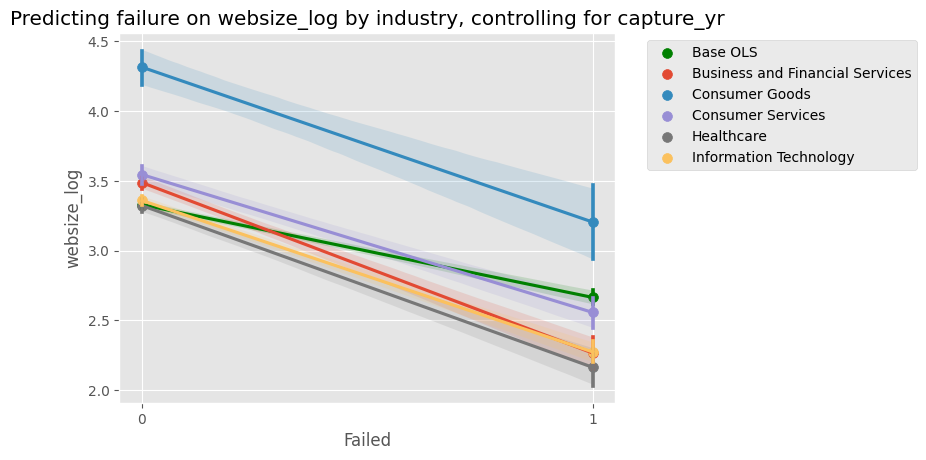

In [31]:
plot_freg('websize_log', data, control='capture_yr', industry=True, save='websize_log_ind_ey.png')

### Number of A Tags

In [32]:
run_model('a_count', control=['end_yr']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Failed   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     799.7
Date:                Thu, 13 Jul 2023   Prob (F-statistic):               0.00
Time:                        16:45:15   Log-Likelihood:                -3416.1
No. Observations:               16795   AIC:                             6888.
Df Residuals:                   16767   BIC:                             7105.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0053      0.133      0.040      0.968      -0.255       0.265
a_count          -0.0004    2.8e-05    -13.864      0.000      -0.000      -0.000
end_yr_1998.0    -0.0013      0.149     -0.009      0.993      -0.294       0.291
end_yr_1999.0     0.0030      0.135      0.022      0.982      -0.262       0.268
end_yr_2000.0     0.0029      0.134      0.022      0.983      -0.260       0.266
end_yr_2001.0     0.0021      0.134      0.015      0.988      -0.261       0.265
end_yr_2002.0     0.0022      0.134      0.017      0.987      -0.261       0.265
end_yr_2003.0     0.0078      0.134      0.058      0.954      -0.255       0.271
end_yr_2004.0     0.0029      0.134      0.021      0.983      -0.259       0.265
end_yr_2005.0     0.0071      0.134      0.053      0.958      -0.255       0.270
end_yr_2006.0     0.0076      0.134      0.057      0.955      -0.254       0.270
end_yr_2007.0     0.0101      0.134      0.075      0.940      -0.252       0.272
end_yr_2008.0     0.0213      0.134      0.159      0.874      -0.241       0.284
end_yr_2009.0     0.0140      0.134      0.104      0.917      -0.248       0.276
end_yr_2010.0     0.0190      0.133      0.143      0.887      -0.242       0.280
end_yr_2011.0     0.0192      0.133      0.144      0.885      -0.242       0.281
end_yr_2012.0     0.0170      0.133      0.127      0.899      -0.244       0.278
end_yr_2013.0     0.0209      0.133      0.157      0.876      -0.240       0.282
end_yr_2014.0     0.0208      0.133      0.156      0.876      -0.240       0.282
end_yr_2015.0     0.0179      0.133      0.134      0.893      -0.243       0.279
end_yr_2016.0     0.0218      0.133      0.164      0.870      -0.239       0.283
end_yr_2017.0     0.0218      0.133      0.164      0.870      -0.239       0.283
end_yr_2018.0     0.0210      0.133      0.158      0.874      -0.240       0.282
end_yr_2019.0     0.0232      0.133      0.174      0.862      -0.238       0.284
end_yr_2020.0     0.0881      0.140      0.629      0.530      -0.187       0.363
end_yr_2021.0     0.0303      0.134      0.226      0.821      -0.232       0.293
end_yr_2022.0     0.0387      0.134      0.289      0.772      -0.224       0.301
end_yr_2023.0     0.6953      0.133      5.236      0.000       0.435       0.956
==============================================================================
Omnibus:                     2758.941   Durbin-Watson:                   1.613
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4496.440
Skew:                          -1.118   Prob(JB):                         0.00
Kurtosis:                       4.193   Cond. No.                     2.88e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of th

## Difference in final screenshot and end year

This is somewhat promising...maybe we couldchange this to a more precise number by including month too?

In [139]:
data['finalsnap_end_diff'] = data['end_yr'] - data['capture_yr']

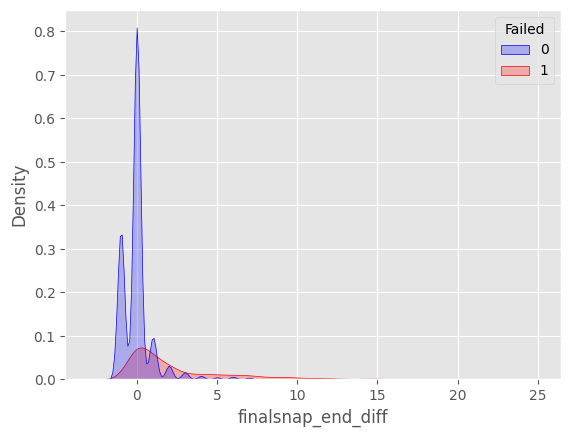

In [140]:
sns.kdeplot(data=data, x='finalsnap_end_diff', hue='Failed', palette=['b', 'r'], fill=True);

In [35]:
data[data.Failed == 1].finalsnap_end_diff.describe()

count    4687.000000
mean        2.664818
std         3.717236
min        -1.000000
25%         0.000000
50%         1.000000
75%         4.000000
max        23.000000
Name: finalsnap_end_diff, dtype: float64

In [36]:
data[data.Failed == 0].finalsnap_end_diff.describe()

count    12108.000000
mean         0.069128
std          1.415940
min         -1.000000
25%         -1.000000
50%          0.000000
75%          0.000000
max         21.000000
Name: finalsnap_end_diff, dtype: float64

In [150]:
run_model('finalsnap_end_diff', control=['new_industrygroup']).pvalues

const                                               2.719530e-171
finalsnap_end_diff                                   0.000000e+00
new_industrygroup_Consumer Goods                     7.315090e-13
new_industrygroup_Consumer Services                  4.095045e-16
new_industrygroup_Energy and Utilities               2.326534e-04
new_industrygroup_Healthcare                         1.714787e-03
new_industrygroup_Industrial Goods and Materials     1.002349e-02
new_industrygroup_Information Technology             2.103740e-02
new_industrygroup_To Be Assigned                     4.310305e-02
dtype: float64

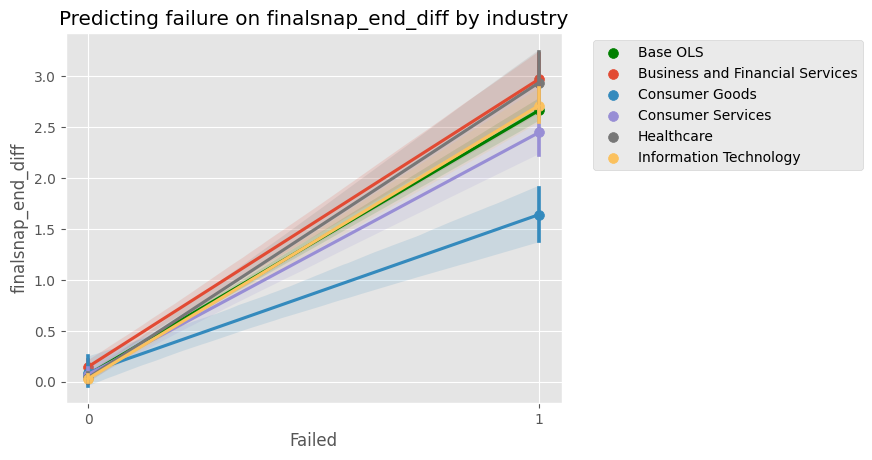

In [38]:
plot_freg('finalsnap_end_diff', data, industry=True, save='endDiff.png')

## Cross-Sectional Regression Table

Create empty DataFrame

In [50]:
reg_results = pd.DataFrame(columns=['X', 'Y', 'Coefficient', 'Control', 'T', 'PValue', 'RSquared'])

In [51]:
data.columns

Index(['yr_from_start', 'capture_yr', 'capture_m', 'file_path', 'file_exists',
       'website_size_kb', 'careers', 'blog', 'login', 'contact', 'team',
       'about', 'news', 'faq', 'call_to_action', 'testimonial', 'title',
       'description', 'keywords', 'p_count', 'h_count', 'img_count', 'a_count',
       'table_count', 'form_count', 'script_count', 'entityname',
       'new_industrygroup', 'state', 'weburl', 'pb_companyid', 'startdate',
       'lastVC', 'ownershipstatus', 'exit_date', 'Failed', 'has_exit',
       'end_yr', 'start_yr', 'lifespan', 'websize_log', 'a_log'],
      dtype='object')

Define columns to run regressions on

In [52]:
cols_of_interest = [i for i in data.select_dtypes(include='number') if i not in ['Failed', 'has_exit']]

In [53]:
data['a_log'].describe()

count    16795.000000
mean         2.866734
std          1.680607
min          0.000000
25%          1.791759
50%          3.332205
75%          4.094345
max          8.376090
Name: a_log, dtype: float64

In [58]:
for i in cols_of_interest:
    print(i)
    mod = run_model(i)
    results = {
        'X': i,
        'Y': 'Failed',
        'Coefficient': mod.params[i],
        'Control': "",
        'T': mod.tvalues[i],
        'PValue': mod.pvalues[i],
        'RSquared': mod.rsquared,
    }
    reg_results = reg_results.append(results, ignore_index=True)
    # Control for end year, industry, state, and start year
    mod = run_model(i, control=['end_yr', 'new_industrygroup', 'state', 'start_yr'])
    results['Coefficient'] = mod.params[i]
    results['PValue'] =  mod.pvalues[i]
    results['RSquared'] = mod.rsquared
    results['Control'] = 'End Year, Industry, State, Year founded'
    reg_results = reg_results.append(results, ignore_index=True)

yr_from_start
capture_yr
capture_m
file_exists
website_size_kb
careers
blog
login
contact
team
about
news
faq
call_to_action
testimonial
title
description
keywords
p_count
h_count
img_count
a_count
table_count
form_count
script_count
end_yr
start_yr
lifespan
websize_log
a_log


Convert R-Squared out of scientific notation

In [55]:
reg_results['RSquared'] = reg_results['RSquared'].astype('float64')
reg_results['RSquared'] = np.round(reg_results['RSquared'], 4)

In [56]:
reg_results.name = 'Last screenshot cross-sectional regressions'

Sort by R-Squared

In [57]:
reg_results.sort_values('RSquared', ascending=False).reset_index(drop=True).head(15)

,X,Y,Coefficient,Control,T,PValue,RSquared
0,websize_log,Failed,-0.056120,"End Year, Industry, State, Year founded",-26.572412,3.505475e-274,0.6321
1,a_log,Failed,-0.048641,"End Year, Industry, State, Year founded",-48.929373,1.788031e-271,0.6318
2,script_count,Failed,-0.003858,"End Year, Industry, State, Year founded",-14.675582,5.813947e-177,0.6221
3,careers,Failed,-0.109098,"End Year, Industry, State, Year founded",-29.229890,3.988166e-121,0.6162
4,website_size_kb,Failed,-0.000369,"End Year, Industry, State, Year founded",-4.349538,5.324898e-99,0.6138
5,h_count,Failed,-0.003031,"End Year, Industry, State, Year founded",-10.417916,6.221258e-94,0.6133
6,call_to_action,Failed,-0.091338,"End Year, Industry, State, Year founded",-12.122288,1.652288e-82,0.6121
7,description,Failed,-0.087768,"End Year, Industry, State, Year founded",-20.964851,1.802495e-81,0.6120
8,about,Failed,-0.089398,"End Year, Industry, State, Year founded",-9.840133,8.162258e-80,0.6118
9,capture_yr,Failed,-0.018218,"End Year, Industry, State, Year founded",60.745970,2.728970e-78,0.6116


## Cross-Sectional Regressions-Difference Between Final Screenshots

**Setup**

Create more of these "growth" columns

In [15]:
def find_last_diff(x, col):
    if len(x.index) > 2:
        second_to_last = x.iloc[-3][col]
        last = x.iloc[-1][col]
        return (last - second_to_last)
    return None

In [16]:
def add_last_growth_col(col, colName):
    s = html.groupby('entityid').apply(lambda x: find_last_diff(x, col))
    s.name = colName
    return html.merge(s, on='entityid')

Add these growth columns for every column that we care about

In [21]:
g_cols_of_interest = ['website_size_kb',
                     'p_count',
                     'h_count',
                      'a_count',
                     'img_count',
                     'table_count',
                     'form_count',
                     'script_count',
    ]

In [22]:
for i in g_cols_of_interest:
    colName = f"l3g_{i}"
    html = add_last_growth_col(col=i, colName=colName)    

In [26]:
html.columns

Index(['entityid', 'yr_from_start', 'capture_yr', 'capture_m', 'file_path',
       'file_exists', 'website_size_kb', 'careers', 'blog', 'login', 'contact',
       'team', 'about', 'news', 'faq', 'call_to_action', 'testimonial',
       'title', 'description', 'keywords', 'p_count', 'h_count', 'img_count',
       'a_count', 'table_count', 'form_count', 'script_count', 'entityname',
       'new_industrygroup', 'state', 'weburl', 'pb_companyid', 'startdate',
       'lastVC', 'ownershipstatus', 'exit_date', 'Failed', 'has_exit',
       'end_yr', 'start_yr', 'lifespan', 'l3g_website_size_kb_x',
       'l3g_p_count_x', 'l3g_h_count_x', 'l3g_a_count_x', 'l3g_img_count_x',
       'l3g_website_size_kb_y', 'l3g_p_count_y', 'l3g_h_count_y',
       'l3g_a_count_y', 'l3g_img_count_y', 'l3g_table_count', 'l3g_form_count',
       'l3g_script_count'],
      dtype='object')

Redefine "data" with new growth columns

In [23]:
data = html.groupby('entityid').last()

In [24]:
growth_reg_results = pd.DataFrame(columns=['X', 'Y', 'Coefficient', 'Control', 'PValue', 'RSquared'])

In [25]:
data = data.dropna(subset=["l3g_" + i for i in g_cols_of_interest if i != 'websize_log'])

KeyError: ['l3g_website_size_kb', 'l3g_p_count', 'l3g_h_count', 'l3g_a_count', 'l3g_img_count']

In [32]:
for i in g_cols_of_interest:
    i = "l3g_" + i
    mod = run_model(i)
    results = {
        'X': i,
        'Y': 'Failed',
        'Coefficient': mod.params[i],
        'Control': "",
        'PValue': mod.pvalues[i],
        'RSquared': mod.rsquared,
    }
    growth_reg_results = growth_reg_results.append(results, ignore_index=True)
    # Control for industry
    mod = run_model(i, control=['new_industrygroup'])
    results['Coefficient'] = mod.params[i]
    results['PValue'] =  mod.pvalues[i]
    results['RSquared'] = mod.rsquared
    results['Control'] = 'industry'
    growth_reg_results = growth_reg_results.append(results, ignore_index=True)
    # Control for end year
    mod = run_model(i, control=['end_yr'])
    results['Coefficient'] = mod.params[i]
    results['PValue'] =  mod.pvalues[i]
    results['RSquared'] = mod.rsquared
    results['Control'] = 'End Year'
    growth_reg_results = growth_reg_results.append(results, ignore_index=True)
    # Control for end year and industry
    mod = run_model(i, control=['end_yr', 'new_industrygroup'])
    results['Coefficient'] = mod.params[i]
    results['PValue'] =  mod.pvalues[i]
    results['RSquared'] = mod.rsquared
    results['Control'] = 'End Year AND Industry'
    growth_reg_results = growth_reg_results.append(results, ignore_index=True)

NameError: name 'g_cols_of_interest' is not defined

Convert R-Squared out of scientific notation

In [292]:
growth_reg_results['RSquared'] = reg_results['RSquared'].astype('float64')
growth_reg_results['RSquared'] = np.round(reg_results['RSquared'], 4)

In [293]:
growth_reg_results.name = 'Last screenshot cross-sectional regressions'

Sort by R-Squared

In [294]:
growth_reg_results.sort_values('RSquared', ascending=False).reset_index(drop=True).head(15)

,X,Y,Coefficient,Control,PValue,RSquared
0,l2g_yr_from_start,Failed,0.095062,industry,1.487018e-202,0.0630
1,l2g_login,Failed,0.025919,industry,2.918746e-01,0.0630
2,l2g_yr_from_start,Failed,0.094355,,1.245471e-197,0.0525
3,l2g_login,Failed,0.030057,,2.237321e-01,0.0525
4,l2g_login,Failed,0.014569,End Year,3.768691e-01,0.0028
5,l2g_yr_from_start,Failed,0.041118,End Year,1.527413e-81,0.0028
6,l2g_website_size_kb,Failed,0.000004,End Year AND Industry,8.937813e-01,0.0010
7,l2g_about,Failed,0.011428,End Year AND Industry,3.344866e-01,0.0010
8,l2g_news,Failed,0.008262,End Year,5.095367e-01,0.0005
9,l2g_news,Failed,-0.001012,industry,9.567580e-01,0.0005


### Change in Website Size

First, create the statistic

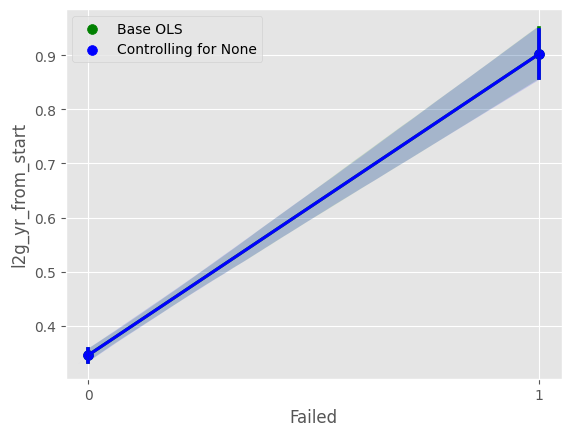

In [295]:
plot_freg('l2g_yr_from_start', data)

### Change in A Tag Count

In [134]:
html = add_last_growth_col('a_count', 'a_lgrowth_raw')